Getting a bit into the world of mathematical finance, we will tackle the Black-Scholes model and the associated Black-Scholes PDE.

The unnderying theory of the model is this: Assuming you are holding 1 stock in which its value (or payoff) can be measured as a function $V(S,t)$ where $S$ is the stock-price and $t$ is the time then further assume that the stock price follows or evolves as the [Geometric Brownian Motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion), sometimes known as the exponential return process
$$
    dS = \mu S dt + \sigma S dW
$$.
The $\mu$ parameter is called the drift or the expected returns while the $\sigma$ is the volatility parameter which is the fluctuations in the returns and $W_t$ is a Wierner process $dW_t \sim \mathcal{N}(0,1)$ then using the [It&ocirc; lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma) we can compute the stochastic differential $dV$ as
$$\begin{align*}
	dV = \left(\frac{\partial V}{\partial t} + \mu S\frac{\partial V}{\partial S} + \frac{(\sigma S)^2}{2}\right)dt + \sigma S\frac{\partial V}{\partial S}dW
\end{align*}$$


and the concept of self-financing portfolio we can introduce a risk-free rate $r$ and eliminate the risk (that is, the $dW$ term) to arrive at the infamous PDE
$$\begin{align*}
	\frac{\partial V}{\partial t}+ \frac{\sigma^2 S^2}{2} + rS\frac{\partial V}{\partial S} - rV= 0
\end{align*}$$

see this [video](https://www.youtube.com/watch?v=A5w-dEgIU1M) for more contexts.

We will try to develop a PINN that can solve the European call option for this PDE which is a **terminal condition** problem where instead of knowing the initial condtion, and solving for the final state, we do the opposite. We are given a strike price $K$ and the final payoff function $V(S,T) = \max()$ at the time of maturity $t=T$ and our job is to go back in time to solve for the initial condition.

Classically, one would do the variable change $\tau = T-t$ and $x = \ln\left(\frac{S}{K}\right)$ to transform the problem into the standard forward heat equation which gives the closed-form solution
$$\begin{align*}
    V_{analytical}(S,t) = S\Phi(d_+) - Ke^{-r(T-t)}\Phi(d_-)
\end{align*}$$
where $\Phi(z)$ is the cummulative distribution function (CDF) of the standard normal distribution and
$$\begin{align*}
    d_+ = \frac{1}{\sigma\sqrt{T-t}} \left( \ln\left(\frac{S}{K}\right) + t\left(\frac{r + \frac{\sigma^2}{2}}{2}\right) \right) \qquad \text{with} \qquad d_- = d_+ - \sigma\sqrt{t}
\end{align*}$$

So in this notebook, we will develop a Neural Network that can solve the European call option for the Black-Scholes PDE which posed on the price-time domain $(S,t) \in [S_{min}, \infty] \times [0,T]$.  Do note that $\mu, \sigma, r$ are given parameters to the PDE. In practice, one would need to derive them from calibrating market data, but here, we can hard-code them to create a model and benchmark. Of course, the above analytical solution is imposed upon the condition
$$\begin{align*}
    & V(S,T) = \max(S-K, 0) \\
    & \lim_{S \to \infty} V(S,t) = S - Ke^{-r(T-t)} \\
    & V(S_{min}, t) = 0
\end{align*}$$


**Remark**: One of the nice thing about PINNs and Neural Networks in general is that not only that they are a statistical model, but they are also continuous approximator meaning that compare to classical numerical methods, you don't need to make special treatment as how you handle time (i.e. no time-stepping), you will treat time-direction exactly similar to how you would treat spatial dimensions and if you are able to work this model out, it will become evident to you.

To develop a NN that can solve the EU Call Option for BS PDE as mentioned, we need to import the necessary libraries. Afterwards, we will create a function for the BS EU Call Option + placeholder parameter values.

In [1]:
%pip install torch numpy matplotlib scipy

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.8.0+cu126
Device: cpu


In [2]:
K = 100.0 # Strike price
T = 1.0 # Time to maturity, expressed in years
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
S_min = 0.0 # Minimum stock price
S_max = 200.0 # Maximum stock price
t = 0 # Current time (0 = time today)

def black_scholes_call(S, t, K, T, r, sigma):
    tau = T - t
    # Handle terminal condition using np.where for element-wise comparison
    if isinstance(tau, np.ndarray):
        # For array inputs, calculate call price where tau > 0, otherwise use max(S-K, 0)
        d_plus = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d_minus = d_plus - sigma * np.sqrt(tau)
        call_price = np.where(tau > 0, S * norm.cdf(d_plus) - K * np.exp(-r * tau) * norm.cdf(d_minus), np.maximum(S - K, 0))
    else:
        # For scalar inputs, use original logic
        if tau <= 0:
            return np.maximum(S - K, 0)
        d_plus = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d_minus = d_plus - sigma * np.sqrt(tau)
        call_price = S * norm.cdf(d_plus) - K * np.exp(-r * tau) * norm.cdf(d_minus)

    return call_price

print(f"Parameters: K={K}, T={T}, r={r}, sigma={sigma}")

Parameters: K=100.0, T=1.0, r=0.05, sigma=0.2


In [3]:
class BlackScholesPINN(nn.Module):
    # set suitable hidden layers + neurons -> prevent over and underfitting
    def __init__(self, hidden_layers=3, neurons=32):
        super(BlackScholesPINN, self).__init__()

        # Build the network: input (S, t) -> output V
        layers = []
        layers.append(nn.Linear(2, neurons))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(neurons, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, S, t):
        """
        Forward pass: predict option value V(S, t)
        S: stock price tensor
        t: time tensor
        """
        x = torch.cat([S, t], dim=1)
        V = self.network(x)
        return V

model = BlackScholesPINN(hidden_layers=4, neurons=32)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 3297 parameters


In the cell above, we define the architecture for our Physics-Informed Neural Network (PINN) that will be used to approximate the solution to the Black-Scholes PDE. The model is built using PyTorch and consists of several fully connected layers (also called hidden layers), each with a specified number of neurons and activation functions (here, Tanh). The input to the network is a pair of values: stock price ($S$) and time ($t$), and the output is the predicted option value:

$$
V(S, t) \approx \mathcal{N}(S, t; \theta)
$$
where $\mathcal{N}$ is the neural network with parameters $\theta$ (weights and biases), and $V(S, t)$ is the model's output for given inputs $S$ and $t$.

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Learning rate

# PDE residual computation using automatic differentiation
def compute_pde_residual(model, S, t, r, sigma):
    S.requires_grad_(True)
    t.requires_grad_(True)

    V = model(S, t)

    # First derivatives
    V_t = torch.autograd.grad(V.sum(), t, create_graph=True)[0]
    V_S = torch.autograd.grad(V.sum(), S, create_graph=True)[0]

    # Second derivative with respect to S
    V_SS = torch.autograd.grad(V_S.sum(), S, create_graph=True)[0]

    # Black-Scholes PDE: ∂V/∂t + (σ²S²/2)∂²V/∂S² + rS∂V/∂S - rV = 0
    pde_residual = V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V

    return pde_residual

def generate_training_data(n_pde=900, n_boundary=100): # Controlling training points
    # PDE collocation points
    S_pde = torch.rand(n_pde, 1) * (S_max - S_min) + S_min
    t_pde = torch.rand(n_pde, 1) * T

    # Terminal condition: V(S, T) = max(S - K, 0)
    S_terminal = torch.rand(n_boundary, 1) * (S_max - S_min) + S_min
    t_terminal = torch.ones(n_boundary, 1) * T
    V_terminal = torch.maximum(S_terminal - K, torch.zeros_like(S_terminal))

    # Lower boundary: V(S_min, t) = 0
    S_lower = torch.ones(n_boundary, 1) * S_min
    t_lower = torch.rand(n_boundary, 1) * T
    V_lower = torch.zeros(n_boundary, 1)

    # Upper boundary: V(S_max, t) ≈ S_max - K*exp(-r(T-t))
    S_upper = torch.ones(n_boundary, 1) * S_max
    t_upper = torch.rand(n_boundary, 1) * T
    V_upper = S_upper - K * torch.exp(-r * (T - t_upper))

    return (S_pde, t_pde), (S_terminal, t_terminal, V_terminal), \
           (S_lower, t_lower, V_lower), (S_upper, t_upper, V_upper)

After setting up the PDE residual function in the previous cell, if our network predicts $V(S, t)$ perfectly, this equation will be close to zero everywhere.

Epoch 200/5000, Loss: 101294.773438, PDE: 0.239073, Terminal: 1491.034424
Epoch 400/5000, Loss: 86170.796875, PDE: 19.149014, Terminal: 1169.604736
Epoch 600/5000, Loss: 73361.859375, PDE: 23.592463, Terminal: 936.120544
Epoch 800/5000, Loss: 62275.320312, PDE: 15.806677, Terminal: 745.808533
Epoch 1000/5000, Loss: 52625.765625, PDE: 12.128590, Terminal: 589.898926
Epoch 1200/5000, Loss: 44217.000000, PDE: 11.547916, Terminal: 461.859222
Epoch 1400/5000, Loss: 36897.167969, PDE: 13.771466, Terminal: 357.025696
Epoch 1600/5000, Loss: 30537.552734, PDE: 11.841132, Terminal: 270.926697
Epoch 1800/5000, Loss: 25059.890625, PDE: 12.831630, Terminal: 202.142929
Epoch 2000/5000, Loss: 20372.705078, PDE: 14.414853, Terminal: 147.966431
Epoch 2200/5000, Loss: 16396.707031, PDE: 16.877172, Terminal: 106.310722
Epoch 2400/5000, Loss: 13051.127930, PDE: 20.852686, Terminal: 74.841652
Epoch 2600/5000, Loss: 10262.124023, PDE: 26.273554, Terminal: 51.673119
Epoch 2800/5000, Loss: 7963.377441, PDE: 3

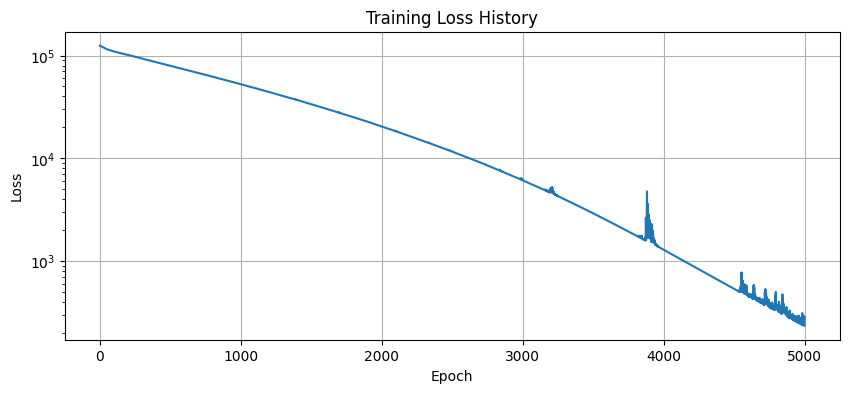

In [7]:
# Training loop
epochs = 5000 # dont train too much -> overfitting
loss_history = []

pde_data, terminal_data, lower_data, upper_data = generate_training_data(n_pde=2000, n_boundary=200)

for epoch in range(epochs):
    optimizer.zero_grad()

    # PDE loss
    S_pde, t_pde = pde_data
    pde_residual = compute_pde_residual(model, S_pde, t_pde, r, sigma)
    loss_pde = torch.mean(pde_residual**2)

    # Terminal condition loss
    S_term, t_term, V_term = terminal_data
    V_pred_term = model(S_term, t_term)
    loss_terminal = torch.mean((V_pred_term - V_term)**2)

    # Lower boundary loss
    S_low, t_low, V_low = lower_data
    V_pred_low = model(S_low, t_low)
    loss_lower = torch.mean((V_pred_low - V_low)**2)

    # Upper boundary loss
    S_up, t_up, V_up = upper_data
    V_pred_up = model(S_up, t_up)
    loss_upper = torch.mean((V_pred_up - V_up)**2)

    # Total loss (weighted sum)
    loss = loss_pde + 10 * loss_terminal + 10 * loss_lower + 10 * loss_upper

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, "
              f"PDE: {loss_pde.item():.6f}, Terminal: {loss_terminal.item():.6f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.yscale('log')
plt.grid(True)
plt.show()

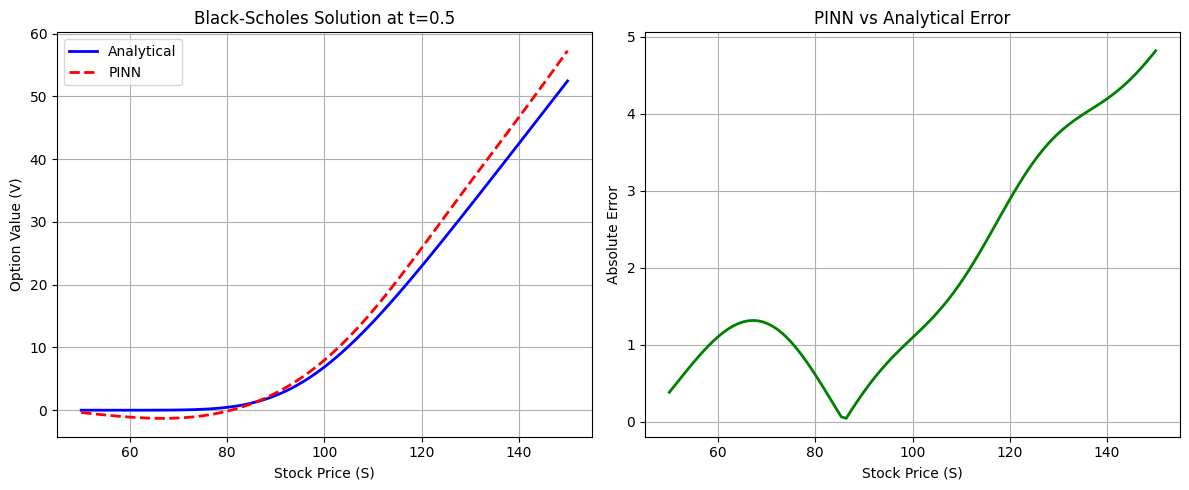

Mean Absolute Error: 1.969478


In [8]:
# Compare PINN solution with analytical solution
model.eval()

# Create test grid
S_test = np.linspace(50, 150, 100)
t_test = 0.5  # Test at t = 0.5

# PINN prediction
S_tensor = torch.tensor(S_test.reshape(-1, 1), dtype=torch.float32)
t_tensor = torch.full((len(S_test), 1), t_test, dtype=torch.float32)
with torch.no_grad():
    V_pinn = model(S_tensor, t_tensor).numpy().flatten()

# Analytical solution
V_analytical = black_scholes_call(S_test, t_test, K, T, r, sigma)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(S_test, V_analytical, 'b-', label='Analytical', linewidth=2)
plt.plot(S_test, V_pinn, 'r--', label='PINN', linewidth=2)
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Value (V)')
plt.title(f'Black-Scholes Solution at t={t_test}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(S_test, np.abs(V_analytical - V_pinn), 'g-', linewidth=2)
plt.xlabel('Stock Price (S)')
plt.ylabel('Absolute Error')
plt.title('PINN vs Analytical Error')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Mean Absolute Error: {np.mean(np.abs(V_analytical - V_pinn)):.6f}")

The image above shows our PINN model solving the Black-Scholes PDE for an EU option halfway to expiration (t=0.5). <br><br>The left plot demonstrates that the neural network (red dashed) closely matches the analytical solution (blue solid) across stock prices from 50-150, and the right plot reveals the PINN's accuracy issues through absolute error.<br><br> From the general looks of things, despite having an MVP and our PINN being fairly decent as is, there's still room for improvement.

/tmp/ipython-input-1233043709.py:14: RuntimeWarning: divide by zero encountered in divide
  d_plus = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


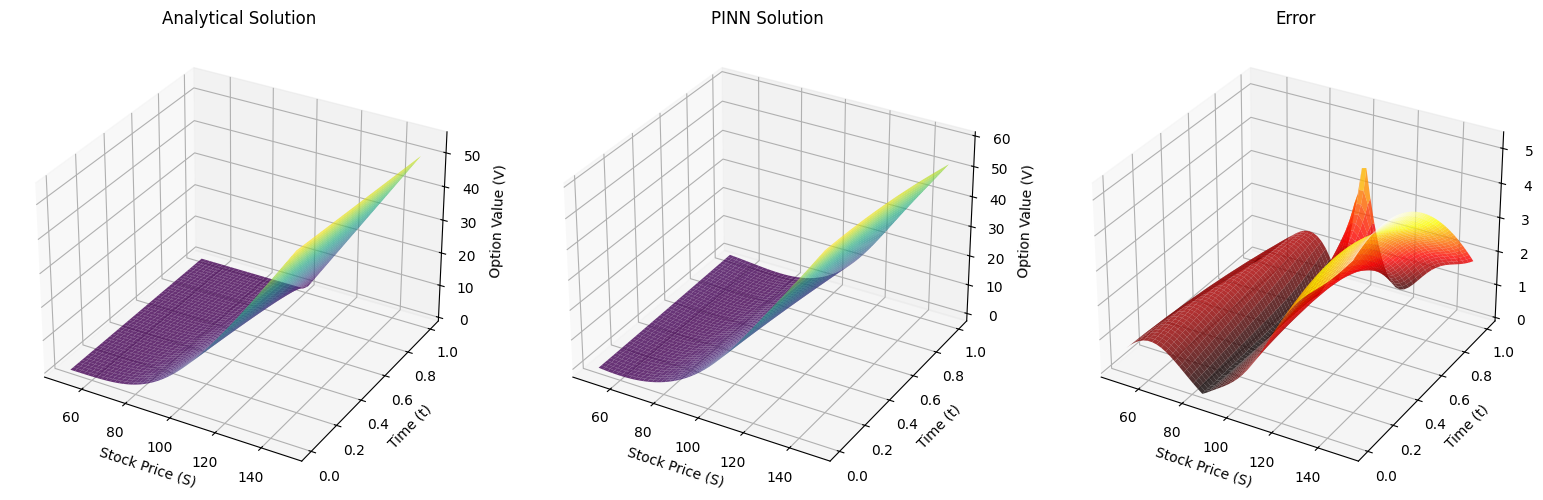

Max Error: 5.359356
Mean Error: 1.812796


In [9]:
# 2D Visualization: Option surface over (S, t) domain
S_grid = np.linspace(50, 150, 50)
t_grid = np.linspace(0, T, 50)
S_mesh, t_mesh = np.meshgrid(S_grid, t_grid)

# PINN predictions
S_flat = torch.tensor(S_mesh.flatten().reshape(-1, 1), dtype=torch.float32)
t_flat = torch.tensor(t_mesh.flatten().reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    V_pinn_surface = model(S_flat, t_flat).numpy().reshape(S_mesh.shape)

# Analytical solution
V_analytical_surface = black_scholes_call(S_mesh, t_mesh, K, T, r, sigma)

# Plot surface comparison
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(S_mesh, t_mesh, V_analytical_surface, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Time (t)')
ax1.set_zlabel('Option Value (V)')
ax1.set_title('Analytical Solution')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(S_mesh, t_mesh, V_pinn_surface, cmap='viridis', alpha=0.8)
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Time (t)')
ax2.set_zlabel('Option Value (V)')
ax2.set_title('PINN Solution')

ax3 = fig.add_subplot(133, projection='3d')
error_surface = np.abs(V_analytical_surface - V_pinn_surface)
ax3.plot_surface(S_mesh, t_mesh, error_surface, cmap='hot', alpha=0.8)
ax3.set_xlabel('Stock Price (S)')
ax3.set_ylabel('Time (t)')
ax3.set_zlabel('Absolute Error')
ax3.set_title('Error')

plt.tight_layout()
plt.show()

print(f"Max Error: {np.max(error_surface):.6f}")
print(f"Mean Error: {np.mean(error_surface):.6f}")

**Next Steps**: Can we fine tune and hyper-parameterize our model to minimize the error?

Lets improve the model's performance using the following techniques:
1. **Learning rate scheduling** with exponential decay: [article reference](https://markaicode.com/learning-rate-scheduling-cosine-linear-exponential-decay/)
2. **Adaptive loss weighting** to balance PDE and boundary losses dynamically: [article reference](https://www.sciencedirect.com/science/article/abs/pii/S092523122200546X)
3. **L-BFGS optimizer** for fine-tuning (used in state-of-the-art PINN implementations): [article reference](https://deepwiki.com/pswpswpsw/nif/4.1-l-bfgs-optimization)
4. **Increased collocation points** for better coverage: [article reference](https://www.sciencedirect.com/science/article/pii/S277241582400018X)

In [13]:
class AdaptiveBlackScholesPINN(nn.Module):
    def __init__(self, hidden_layers=5, neurons=64):
        super(AdaptiveBlackScholesPINN, self).__init__()

        layers = []
        layers.append(nn.Linear(2, neurons))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(neurons, 1))
        self.network = nn.Sequential(*layers)
        self.log_lambda_pde = nn.Parameter(torch.tensor(0.0))
        self.log_lambda_terminal = nn.Parameter(torch.tensor(2.3))
        self.log_lambda_boundary = nn.Parameter(torch.tensor(2.3))

    def get_loss_weights(self):
        """Return positive loss weights using exponential transformation"""
        return (torch.exp(self.log_lambda_pde),
                torch.exp(self.log_lambda_terminal),
                torch.exp(self.log_lambda_boundary))

    def forward(self, S, t):
        x = torch.cat([S, t], dim=1)
        V = self.network(x)
        return V

# Create improved model
improved_model = AdaptiveBlackScholesPINN(hidden_layers=6, neurons=64)
print(f"Improved model parameters: {sum(p.numel() for p in improved_model.parameters())}")

Improved model parameters: 21060


Think of the implementation like this: while a single-layer network *can* theoretically learn any function (this is called the Universal Approximation Theorem), it's like trying to build a house with only basic tools—technically possible, but inefficient. A deeper network is like having specialized tools for each task. Each layer of our network learns progressively more complex patterns:
   $$V(S,t) = f_L \circ f_{L-1} \circ \cdots \circ f_1(S,t)$$
   
   Think of it like learning to read: first you learn letters, then words, then sentences, then paragraphs. Similarly, early layers might learn basic price patterns, while deeper layers combine these into complex option pricing behaviors.

<br>Here's something cool—to achieve the same accuracy, a deep network needs exponentially fewer total neurons than a shallow wide one:
   $$N_{shallow} \sim O\left(\epsilon^{-d/s}\right) \quad \text{vs.} \quad N_{deep} \sim O\left(\epsilon^{-d/(s+1)}\right)$$
   
   Going from 4 to 6 layers means we can achieve better accuracy without exploding our parameter count.

<br> When training, information flows backward through the network as gradients. In very deep or narrow networks, these gradients can shrink to nearly zero ("vanishing gradients"). By using 64 neurons per layer instead of 32, we create wider "highways" for gradients to flow:
   $$\|\nabla_{\theta_1} \mathcal{L}\| \propto \prod_{i=1}^{L} \|\mathbf{W}_i\| \cdot \|g'(z_i)\|$$
   
   Wider layers keep these multiplication factors close to 1, preventing the gradient from vanishing.

Training improved PINN with adaptive weighting and LR scheduling...
Epoch 500/10000, Loss: 32398.218750, PDE: 133.785889, Terminal: 514.476562, LR: 0.000905
  Adaptive weights - λ_pde: 0.429, λ_terminal: 6.214, λ_boundary: 6.364
Epoch 1000/10000, Loss: 8259.056641, PDE: 32.708157, Terminal: 90.235779, LR: 0.000819
  Adaptive weights - λ_pde: 0.266, λ_terminal: 5.286, λ_boundary: 4.736
Epoch 1500/10000, Loss: 2946.804688, PDE: 53.672230, Terminal: 20.158920, LR: 0.000741
  Adaptive weights - λ_pde: 0.189, λ_terminal: 5.065, λ_boundary: 4.195
Epoch 2000/10000, Loss: 1263.059082, PDE: 91.368164, Terminal: 5.769364, LR: 0.000670
  Adaptive weights - λ_pde: 0.133, λ_terminal: 5.009, λ_boundary: 3.985
Epoch 2500/10000, Loss: 529.300903, PDE: 128.875671, Terminal: 1.981104, LR: 0.000607
  Adaptive weights - λ_pde: 0.096, λ_terminal: 4.990, λ_boundary: 3.883
Epoch 3000/10000, Loss: 239.520309, PDE: 173.076019, Terminal: 1.498840, LR: 0.000549
  Adaptive weights - λ_pde: 0.075, λ_terminal: 4.96

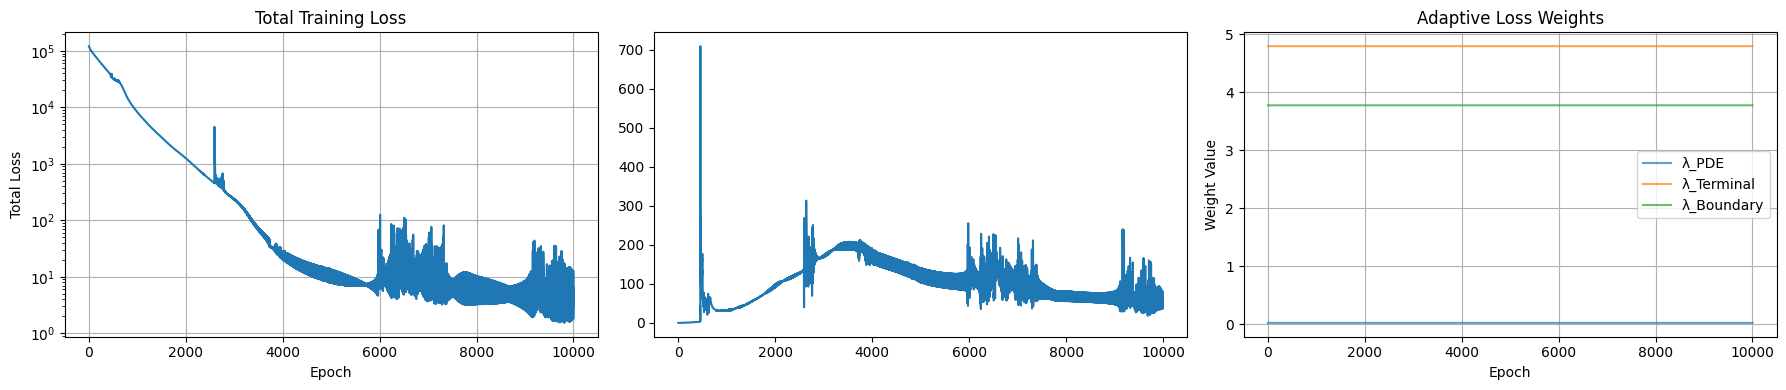

In [15]:
epochs_opt = 10000
initial_lr = 0.001

optimizer_opt = torch.optim.Adam(improved_model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_opt, gamma=0.9998)

pde_data_opt, terminal_data_opt, lower_data_opt, upper_data_opt = generate_training_data(
    n_pde=5000,
    n_boundary=500
)

loss_history_opt = []
pde_loss_history = []
boundary_loss_history = []

print("Training improved PINN with adaptive weighting and LR scheduling...")
for epoch in range(epochs_opt):
    optimizer_opt.zero_grad()

    S_pde, t_pde = pde_data_opt
    pde_residual = compute_pde_residual(improved_model, S_pde, t_pde, r, sigma)
    loss_pde = torch.mean(pde_residual**2)

    S_term, t_term, V_term = terminal_data_opt
    V_pred_term = improved_model(S_term, t_term)
    loss_terminal = torch.mean((V_pred_term - V_term)**2)

    S_low, t_low, V_low = lower_data_opt
    V_pred_low = improved_model(S_low, t_low)
    loss_lower = torch.mean((V_pred_low - V_low)**2)

    S_up, t_up, V_up = upper_data_opt
    V_pred_up = improved_model(S_up, t_up)
    loss_upper = torch.mean((V_pred_up - V_up)**2)
    lambda_pde, lambda_terminal, lambda_boundary = improved_model.get_loss_weights()

    loss = (lambda_pde * loss_pde +
            lambda_terminal * loss_terminal +
            lambda_boundary * (loss_lower + loss_upper))

    loss.backward()

    torch.nn.utils.clip_grad_norm_(improved_model.parameters(), max_norm=1.0)
    boundary_loss_history.append((loss_terminal.item() + loss_lower.item() + loss_upper.item()) / 3)
    optimizer_opt.step()
    scheduler.step()

    loss_history_opt.append(loss.item())
    pde_loss_history.append(loss_pde.item())
    boundary_loss_history.append((loss_terminal.item() + loss_lower.item() + loss_upper.item()) / 3)

    if (epoch + 1) % 500 == 0:
        current_lr = optimizer_opt.param_groups[0]['lr']
        lambda_pde, lambda_terminal, lambda_boundary = improved_model.get_loss_weights()
        print(f"Epoch {epoch+1}/{epochs_opt}, Loss: {loss.item():.6f}, "
              f"PDE: {loss_pde.item():.6f}, Terminal: {loss_terminal.item():.6f}, LR: {current_lr:.6f}")
        print(f"  Adaptive weights - λ_pde: {lambda_pde.item():.3f}, "
              f"λ_terminal: {lambda_terminal.item():.3f}, "
              f"λ_boundary: {lambda_boundary.item():.3f}")
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(loss_history_opt)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Training Loss')
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].plot(pde_loss_history, label='PDE Loss')
lambda_pde_final, lambda_terminal_final, lambda_boundary_final = improved_model.get_loss_weights()
axes[2].plot([lambda_pde_final.item()] * len(loss_history_opt), label='λ_PDE', alpha=0.7)
axes[2].plot([lambda_terminal_final.item()] * len(loss_history_opt), label='λ_Terminal', alpha=0.7)
axes[2].plot([lambda_boundary_final.item()] * len(loss_history_opt), label='λ_Boundary', alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Weight Value')
axes[2].set_title('Adaptive Loss Weights')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

In [17]:
# Fine-tuning with L-BFGS optimizer
def closure():
    optimizer_lbfgs.zero_grad()

    S_pde, t_pde = pde_data_opt
    pde_residual = compute_pde_residual(improved_model, S_pde, t_pde, r, sigma)
    loss_pde = torch.mean(pde_residual**2)

    S_term, t_term, V_term = terminal_data_opt
    V_pred_term = improved_model(S_term, t_term)
    loss_terminal = torch.mean((V_pred_term - V_term)**2)

    S_low, t_low, V_low = lower_data_opt
    V_pred_low = improved_model(S_low, t_low)
    loss_lower = torch.mean((V_pred_low - V_low)**2)

    S_up, t_up, V_up = upper_data_opt
    V_pred_up = improved_model(S_up, t_up)
    loss_upper = torch.mean((V_pred_up - V_up)**2)

    loss = loss_pde + 10 * loss_terminal + 10 * (loss_lower + loss_upper)
    loss.backward()
    return loss

optimizer_lbfgs = torch.optim.LBFGS(
    improved_model.parameters(),
    lr=1.0,
    max_iter=500,
    max_eval=500,
    tolerance_grad=1e-7,
    tolerance_change=1e-9,
    history_size=100,
    line_search_fn="strong_wolfe"
)

optimizer_lbfgs.step(closure)

tensor(23.4565, grad_fn=<AddBackward0>)

To tell you a little but about the implementation above, L-BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) uses smarter information about the landscape to find the optimal solution faster.

**The Key Ideas:**

1. **Newton's Method**: The theoretically best way to optimize uses second-order information (curvature):
   $$\theta_{k+1} = \theta_k - \mathbf{H}_k^{-1} \nabla_\theta \mathcal{L}(\theta_k)$$
   
   where $\mathbf{H}$ is the Hessian matrix (think of it as a map of how curved the loss landscape is). This gives *quadratic* convergence—meaning the error roughly squares at each step. Compare this to Adam's *linear* convergence where you chip away at the error bit by bit.

2. **The Clever Approximation**: Computing the full Hessian is expensive (imagine calculating millions of second derivatives!). L-BFGS cleverly approximates it:
   $$\mathbf{H}_k^{-1} \approx \mathbf{B}_k$$
   
   by tracking how gradients change over recent iterations:
   $$\mathbf{B}_{k+1} = \mathbf{B}_k + \frac{\mathbf{s}_k \mathbf{s}_k^T}{\mathbf{s}_k^T \mathbf{y}_k} - \frac{\mathbf{B}_k \mathbf{y}_k \mathbf{y}_k^T \mathbf{B}_k}{\mathbf{y}_k^T \mathbf{B}_k \mathbf{y}_k}$$
   
   where $\mathbf{s}_k$ is how much the parameters changed and $\mathbf{y}_k$ is how much the gradient changed. It's like building a local map as you explore.

3. **Speed Comparison**:
   - **Adam**: Error decreases like $\sim 1/k$ (if you've done 100 steps, expect 1% error; need 1000 steps for 0.1%)
   - **L-BFGS**: Error decreases like $\sim c^k$ where $c < 1$ (exponential! Each step cuts the error by a constant fraction)
   
   Near the solution, L-BFGS is dramatically faster—it's the difference between walking and teleporting.

4. **Why the Two-Stage Strategy?**
   - **Adam (Stage 1)**: Great at exploration, handles noisy gradients well, gets us to the right neighborhood
   - **L-BFGS (Stage 2)**: Requires clean gradients (full-batch), but excels at precision refinement


/tmp/ipython-input-1233043709.py:14: RuntimeWarning: divide by zero encountered in divide
  d_plus = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


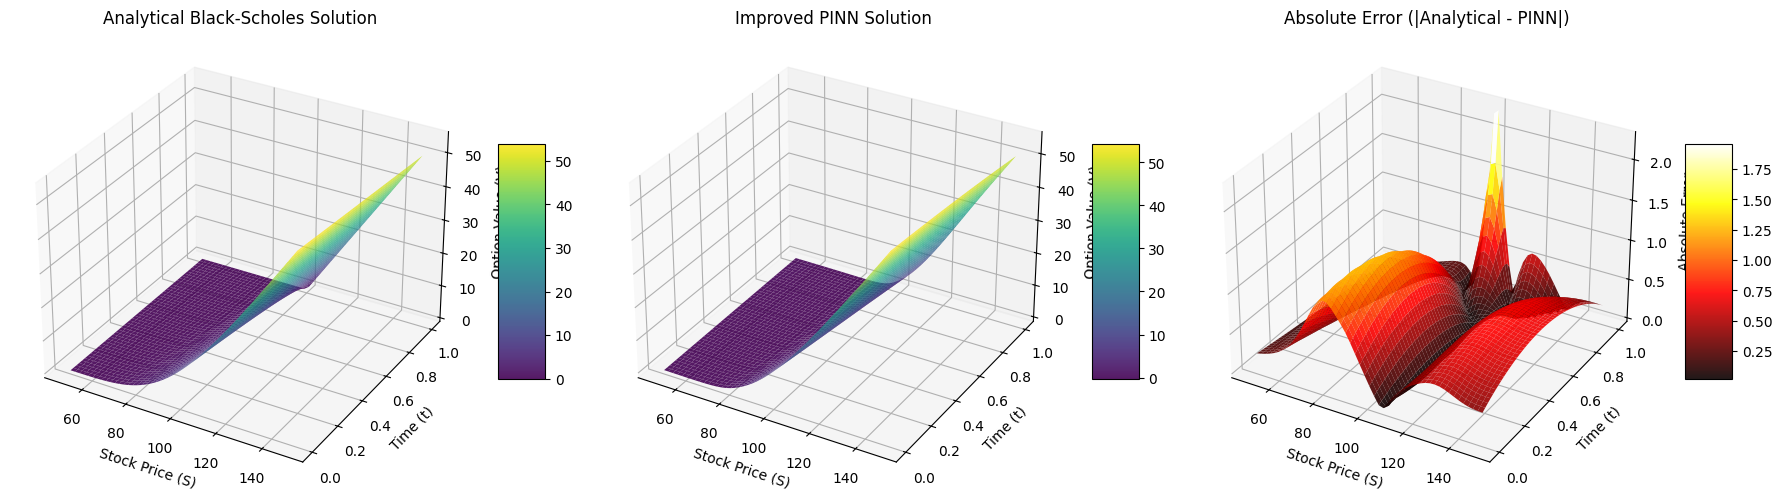

Surface Statistics:
  Max Error: 2.291930
  Mean Error: 0.442158
  Median Error: 0.388457


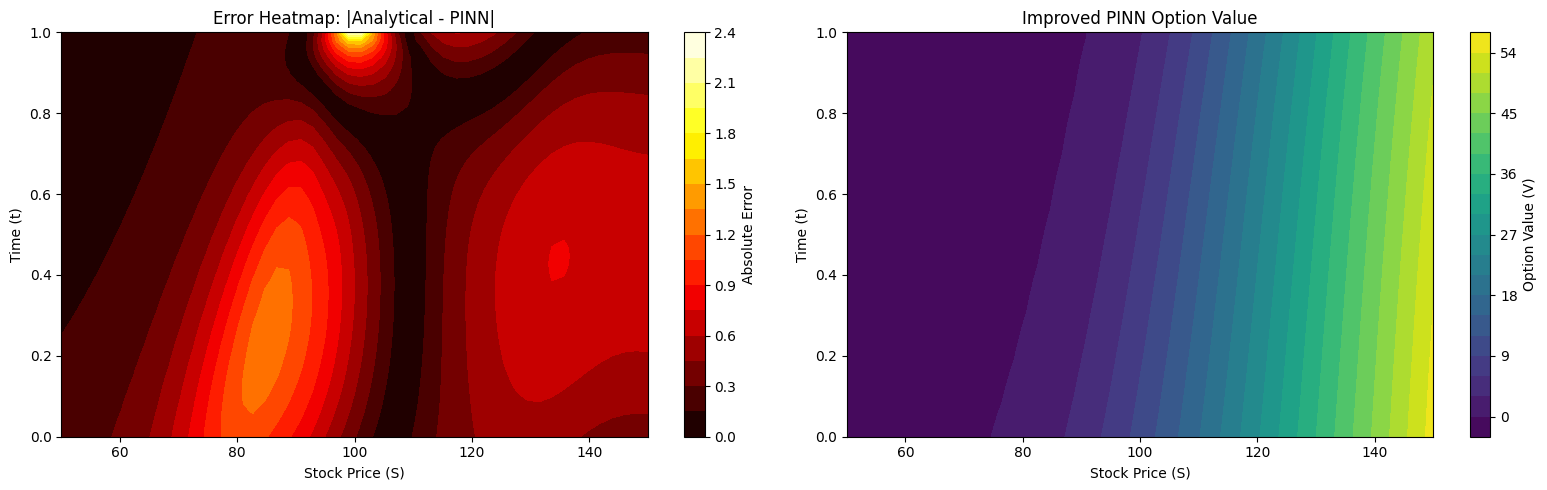


Error Distribution:
  25th percentile: 0.185101
  50th percentile (median): 0.388457
  75th percentile: 0.648463
  95th percentile: 1.090142


In [18]:
# 3D Visualization: Improved PINN vs Analytical Solution
improved_model.eval()

S_grid = np.linspace(50, 150, 50)
t_grid = np.linspace(0, T, 50)
S_mesh, t_mesh = np.meshgrid(S_grid, t_grid)

# PINN predictions
S_flat = torch.tensor(S_mesh.flatten().reshape(-1, 1), dtype=torch.float32)
t_flat = torch.tensor(t_mesh.flatten().reshape(-1, 1), dtype=torch.float32)

with torch.no_grad():
    V_pinn_surface = improved_model(S_flat, t_flat).numpy().reshape(S_mesh.shape)

V_analytical_surface = black_scholes_call(S_mesh, t_mesh, K, T, r, sigma)
error_surface = np.abs(V_analytical_surface - V_pinn_surface)

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(S_mesh, t_mesh, V_analytical_surface, cmap='viridis', alpha=0.9)
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Time (t)')
ax1.set_zlabel('Option Value (V)')
ax1.set_title('Analytical Black-Scholes Solution')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(S_mesh, t_mesh, V_pinn_surface, cmap='viridis', alpha=0.9)
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Time (t)')
ax2.set_zlabel('Option Value (V)')
ax2.set_title('Improved PINN Solution')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(S_mesh, t_mesh, error_surface, cmap='hot', alpha=0.9)
ax3.set_xlabel('Stock Price (S)')
ax3.set_ylabel('Time (t)')
ax3.set_zlabel('Absolute Error')
ax3.set_title('Absolute Error (|Analytical - PINN|)')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

print(f"Surface Statistics:")
print(f"  Max Error: {np.max(error_surface):.6f}")
print(f"  Mean Error: {np.mean(error_surface):.6f}")
print(f"  Median Error: {np.median(error_surface):.6f}")

# 2D Heatmap: Error distribution across (S, t) domain
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

im1 = axes[0].contourf(S_mesh, t_mesh, error_surface, levels=20, cmap='hot')
axes[0].set_xlabel('Stock Price (S)')
axes[0].set_ylabel('Time (t)')
axes[0].set_title('Error Heatmap: |Analytical - PINN|')
fig.colorbar(im1, ax=axes[0], label='Absolute Error')

im2 = axes[1].contourf(S_mesh, t_mesh, V_pinn_surface, levels=20, cmap='viridis')
axes[1].set_xlabel('Stock Price (S)')
axes[1].set_ylabel('Time (t)')
axes[1].set_title('Improved PINN Option Value')
fig.colorbar(im2, ax=axes[1], label='Option Value (V)')

plt.tight_layout()
plt.show()

print(f"\nError Distribution:")
print(f"  25th percentile: {np.percentile(error_surface, 25):.6f}")
print(f"  50th percentile (median): {np.percentile(error_surface, 50):.6f}")
print(f"  75th percentile: {np.percentile(error_surface, 75):.6f}")
print(f"  95th percentile: {np.percentile(error_surface, 95):.6f}")

There! A lot better now.